# HW1_Сравнительный анализ моделей классификации отзывов

**ФИО Студента: Кузнецов Кирилл Игоревич** 

**Дата Выполнения: 09.09.2025**

-----
---

## **1. Подготовка данных и EDA**

### **1.1. Загрузка и подготовка библиотек**

Начнем с установки и импорта необходимых библиотек для нашего проекта.

In [1]:
# # Установка библиотек
# !pip install pymorphy3
# !pip install gensim
# !pip install lime

In [1]:
# Основные библиотеки
import os
import re
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter
import pickle
from datetime import datetime

# NLP библиотеки
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import pymorphy3

# Embeddings
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
import gensim.downloader as api

# ML
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, auc)

# Визуализация
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud

# Интерпретируемость
import shap
import lime

# Настройки
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

# Создание структуры папок
folders = ['data', 'models', 'results', 'visualizations', 'reports']
for folder in folders:
    os.makedirs(folder, exist_ok=True)

# Загрузка ресурсов NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
print("NLTK ресурсы загружены")

# Инициализация морфологического анализатора и стоп-слов
morph = pymorphy3.MorphAnalyzer()
stop_words_ru = set(stopwords.words('russian'))
stop_words_en = set(stopwords.words('english'))

NLTK ресурсы загружены


In [2]:
# Инициализируем рандом сид
RANDOM_STATE = 42

---
### **1.2. Загрузка и первичный анализ данных**

Загрузим датасет и проведем базовый анализ, чтобы понять его структуру.

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  500000 non-null  object
 1   name_ru  499030 non-null  object
 2   rating   500000 non-null  int64 
 3   rubrics  500000 non-null  object
 4   text     500000 non-null  object
dtypes: int64(1), object(4)
memory usage: 19.1+ MB


None

__________________________________________________
Количество пустых строк:address      0
name_ru    970
rating       0
rubrics      0
text         0
dtype: int64
__________________________________________________


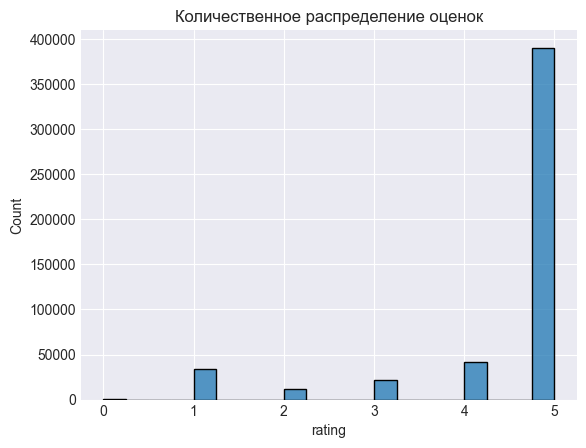

In [3]:
# Загрузка датасета
from datasets import load_dataset
df_raw = load_dataset("d0rj/geo-reviews-dataset-2023")
df_raw = pd.DataFrame(df_raw['train'])

display(df_raw.head())

print("_"*50)
display(df_raw.info())

print("_"*50)
print(f"Количество пустых строк:{df_raw.isna().sum()}")

print("_"*50)
sns.histplot(df_raw["rating"])
plt.title("Количественное распределение оценок")
plt.show()


,address,name_ru,rating,rubrics,text,sentiment
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...",1
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...",0
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,1
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,1
5,"Иркутская область, Черемхово, Первомайская ули...",Tele2,5,Оператор сотовой связи;Интернет-провайдер,"Приятное общение, все доступно объяснили, мне ...",1


Исследовательский анализ данных:

Размер датасета: (478114, 6)

Типы данных:
address      object
name_ru      object
rating        int64
rubrics      object
text         object
sentiment     int64
dtype: object

Пропущенные значения:
address        0
name_ru      936
rating         0
rubrics        0
text           0
sentiment      0
dtype: int64

Распределение классов:
Позитивные (1): 431675 (90.3%)
Негативные (0): 46439 (9.7%)
__________________________________________________


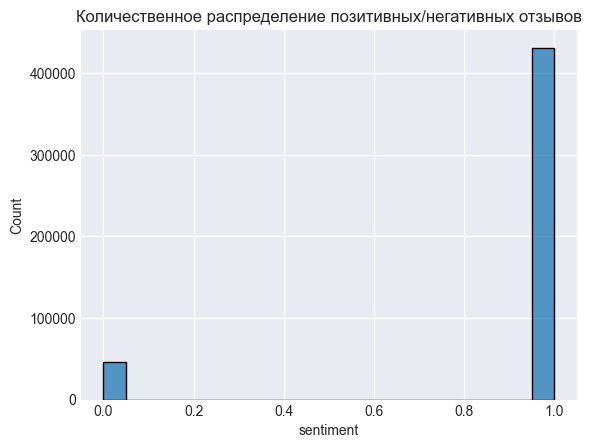

In [4]:
# ЗАДАНИЕ: Удалите нейтральные отзывы (рейтинг 3) и создайте бинарную целевую переменную 'sentiment'.
# 1 - позитивный отзыв (рейтинг 4, 5)
# 0 - негативный отзыв (рейтинг 1, 2)

# Удалите строки с отсутствующими значениями в 'sentiment'.

# Создадим функцию для мапинга рейтинга на 3 группы
# можно сделать прямой маппинг без обходов, т.к. у нас нет пропусков
# и все значения инты

def sentiment(data):
    # группа заглушка (для 3 и 0)
    estimation = "-"
    # позитивный рейтинг
    if data in (4, 5):
        estimation = 1
    # негативный рейтинг
    elif data in (1, 2):
        estimation = 0
    return estimation


# Создадим копию датафрейма

df = df_raw.copy()

df["sentiment"] = df["rating"].apply(sentiment)

# фильтрация по группе "-"
df = df.query("sentiment != '-'")

# приведем к типу целочисленному
df['sentiment'] = df['sentiment'].astype(int)

display(df.head())

# Вывод базовой информации о датасете
print("Исследовательский анализ данных:")
print(f"\nРазмер датасета: {df.shape}")
print(f"\nТипы данных:\n{df.dtypes}")
print(f"\nПропущенные значения:\n{df.isnull().sum()}")

# Распределение классов
class_distribution = df['sentiment'].value_counts()
print("\nРаспределение классов:")
print(
    f"Позитивные (1): {class_distribution.get(1, 0)} ({class_distribution.get(1, 0)/len(df)*100:.1f}%)")
print(
    f"Негативные (0): {class_distribution.get(0, 0)} ({class_distribution.get(0, 0)/len(df)*100:.1f}%)")

print("_"*50)
sns.histplot(df["sentiment"])
plt.title("Количественное распределение позитивных/негативных отзывов")
plt.show()

> На лицо явный дисбаланс классов, произведем семлирование по наименьшему классу, в данный момент доминирует класс позитивных оценок, следовательно мы сэмплируем рандомную выборку по нему, полностью забирая класс 0.

Исследовательский анализ данных:

Размер датасета: (92878, 6)

Типы данных:
address      object
name_ru      object
rating        int64
rubrics      object
text         object
sentiment     int64
dtype: object

Пропущенные значения:
address        0
name_ru      166
rating         0
rubrics        0
text           0
sentiment      0
dtype: int64

Распределение классов:
Позитивные (1): 46439 (50.0%)
Негативные (0): 46439 (50.0%)
__________________________________________________


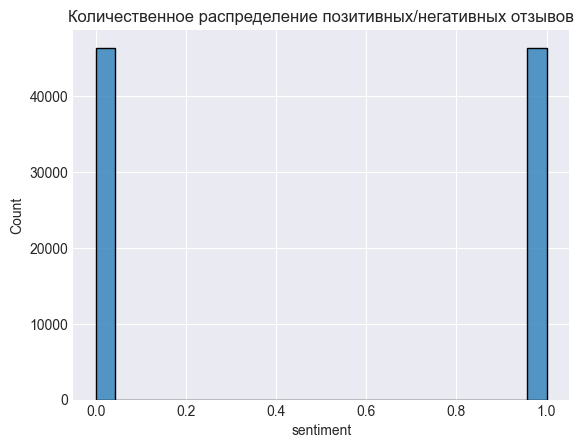

In [5]:
# ЗАДАНИЕ: Сбалансируйте классы, чтобы количество позитивных и негативных отзывов было одинаковым.
# Подсчитываем количество в каждом классе
n_negative = df[df['sentiment'] == 0].shape[0]
n_positive = df[df['sentiment'] == 1].shape[0]

# Определяем минимальный размер
min_count = min(n_negative, n_positive)

# Берём случайную выборку из каждого класса одинакового размера (по минимальному классу)
# хоть класс 0 у нас и попадает в полном составе, но используем подход, который не будет
# зависеть от датасета.
df = pd.concat([
    df[df['sentiment'] == 0].sample(n=min_count, random_state=RANDOM_STATE),
    df[df['sentiment'] == 1].sample(n=min_count, random_state=RANDOM_STATE)
    # перемешиваем
]).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Вывод базовой информации о датасете
print("Исследовательский анализ данных:")
print(f"\nРазмер датасета: {df.shape}")
print(f"\nТипы данных:\n{df.dtypes}")
print(f"\nПропущенные значения:\n{df.isnull().sum()}")

# Распределение классов
class_distribution = df['sentiment'].value_counts()

print("\nРаспределение классов:")
print(
    f"Позитивные (1): {class_distribution.get(1, 0)} ({class_distribution.get(1, 0)/len(df)*100:.1f}%)")
print(
    f"Негативные (0): {class_distribution.get(0, 0)} ({class_distribution.get(0, 0)/len(df)*100:.1f}%)")

print("_"*50)
sns.histplot(df["sentiment"])
plt.title("Количественное распределение позитивных/негативных отзывов")
plt.show()

> Классы сбалансированы. Имеются пропуски в поле name_ru, но задания не указывали очищать эту колонку + в анализе семантики название заведения в лучшем случае не будет иметь значения, а в худшем может привести к утечке данных, так что пока оставим.

---
### **1.3. Исследовательский анализ данных (EDA)**

Проведем более глубокий анализ текстовых данных и визуализируем результаты.

In [6]:
# Создадим копию
df_count = df.copy()
display(df_count.head())

,address,name_ru,rating,rubrics,text,sentiment
0,"Санкт-Петербург, Пушкин, Софийский бульвар, 32",Tsar Palace Luxury Hotel & SPA,5,Гостиница,Мой Любимый отель!🫶🏼 очень уютно.. прекрасная ...,1
1,"Московская область, Воскресенск, микрорайон Це...",Центр суши,5,Доставка еды и обедов;Пиццерия;Магазин суши и ...,Часто заказываю здесь суши и пиццу и могу пред...,1
2,"Москва, Касимовская улица, вл26",Астал-Агро,5,Товары для животных оптом;Товары для дома,Качественный бренд продукции для питомцев. Шир...,1
3,"Пермь, улица Газеты Звезда, 12",The Friends,1,"Кафе;Бар, паб","Гардероб прям на входе, сам свою верхнюю одежд...",0
4,"Московская область, Павловский Посад, Большая ...",Вкус Востока,1,Быстрое питание,Своим наплевательским отношением лишились пост...,0


In [7]:
# ЗАДАНИЕ: Добавьте в датафрейм столбцы с длиной текста, количеством слов и предложений.
df_count['text_length'] = df_count["text"].apply(
    lambda x: len(x))  # подсчитаем длинну строки

# подсчитаем количество слов используя пакетное решение nltk для токенизации слов.
df_count['word_count'] = df_count['text'].apply(
    lambda x: len(word_tokenize(x, language='russian')))

df_count['sentence_count'] = df_count['text'].apply(
    lambda x: len(sent_tokenize(x, language='russian')))

# подсчитаем количество слов по разделителю " ", вклчюая спец-токены, смайлы и тд.
# по итогу остановился на пакетном решении nltk
# df_count['word_count'] = df_count["text"].apply(lambda x: len(x.split()))

# Немного уродливый конвеер подсчета предложений (за основу взял строковые методы пандас и реулярные выражения)
# но по итогу отказался, т.к. токенизация и последующий подсчет оказались точнее через nltk особенно на
# лексически засоренных предложениях.
# df_count['sentence_count'] = df_count["text"].str.replace(
#     r'[!?]', '.', regex=True).str.split(".").str.len()

In [8]:
# Вывод статистик по текстам
print("\nСтатистика текстов:")
print(df_count[['text_length', 'word_count', 'sentence_count']].describe())


Статистика текстов:
        text_length    word_count  sentence_count
count  92878.000000  92878.000000    92878.000000
mean     401.579330     73.031364        5.149992
std      407.980946     76.142993        4.723015
min        2.000000      1.000000        1.000000
25%      166.000000     29.000000        2.000000
50%      275.000000     49.000000        4.000000
75%      496.000000     90.000000        7.000000
max    20162.000000   3606.000000      188.000000


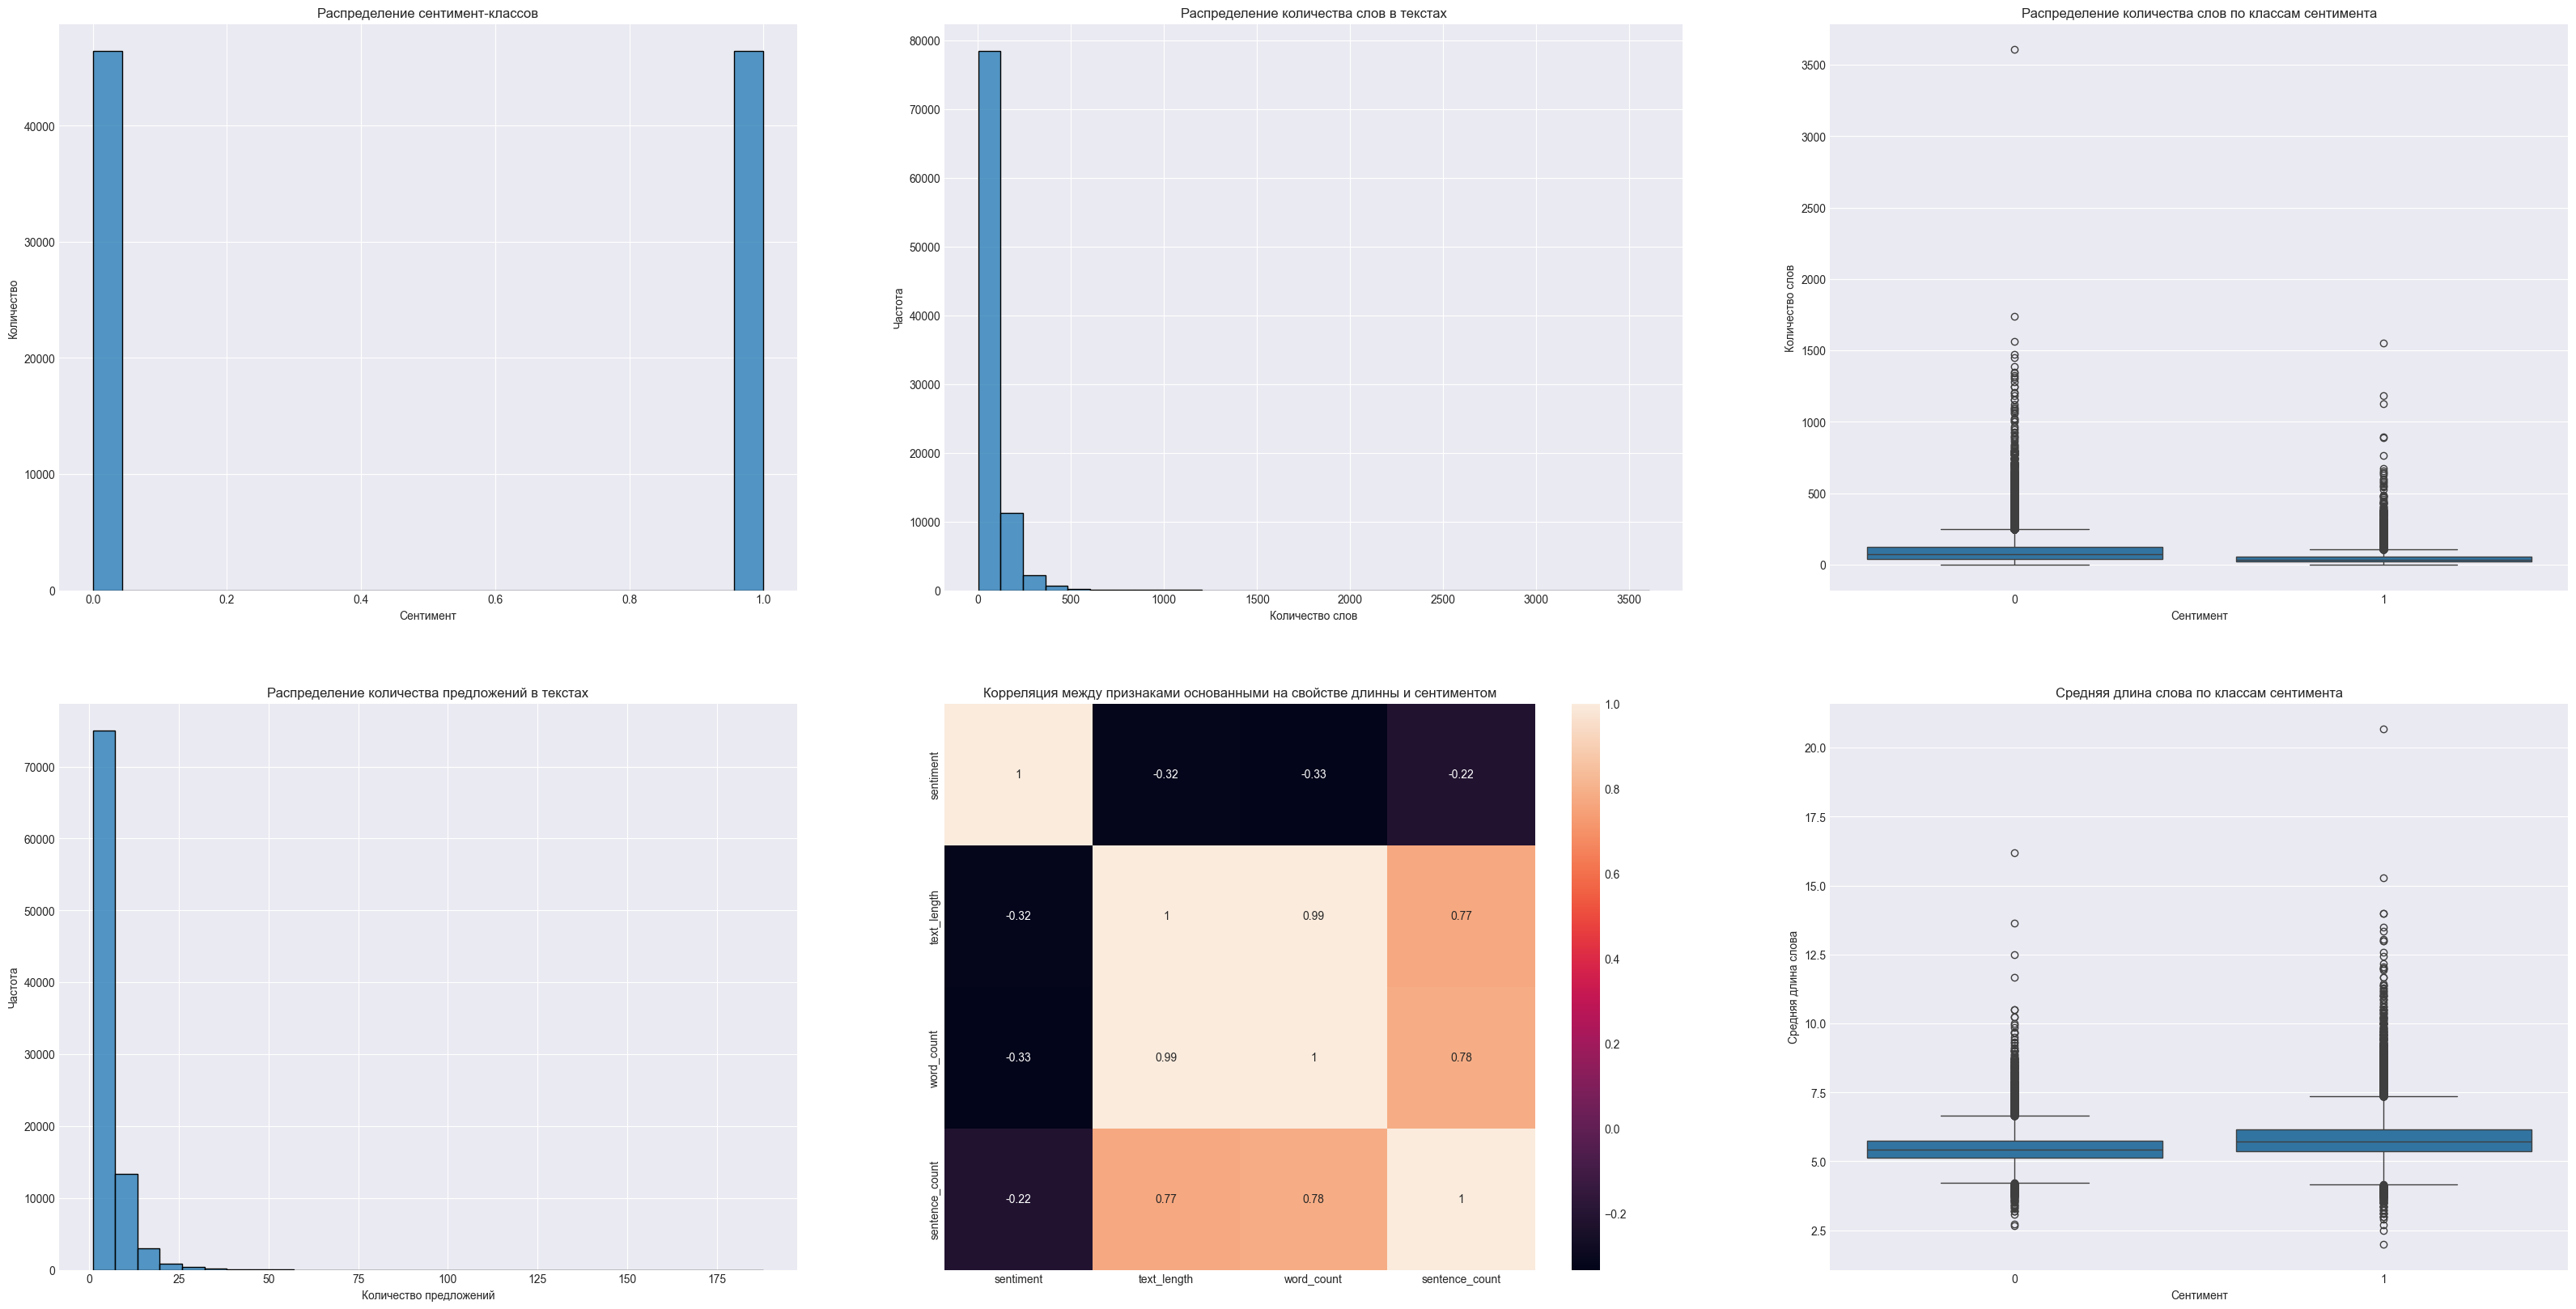

In [9]:
# ЗАДАНИЕ: Создайте 6 графиков для визуализации EDA, например такие:
fig, axes = plt.subplots(2, 3, figsize=(40, 20))

# 1. Распределение классов
sns.histplot(df_count["sentiment"], ax=axes[0][0])
axes[0][0].set_title('Распределение сентимент-классов')
axes[0][0].set_xlabel('Сентимент')
axes[0][0].set_ylabel('Количество')

# 2. Распределение количества слов
sns.histplot(df_count['word_count'], bins=30, ax=axes[0][1])
axes[0][1].set_title('Распределение количества слов в текстах')
axes[0][1].set_xlabel('Количество слов')
axes[0][1].set_ylabel('Частота')

# 3. Boxplot количества слов по классам
sns.boxplot(data=df_count, x='sentiment', y='word_count', ax=axes[0][2])
axes[0][2].set_title('Распределение количества слов по классам сентимента')
axes[0][2].set_xlabel('Сентимент')
axes[0][2].set_ylabel('Количество слов')

# 4. Распределение количества предложений
sns.histplot(df_count['sentence_count'], bins=30, ax=axes[1][0])
axes[1][0].set_title('Распределение количества предложений в текстах')
axes[1][0].set_xlabel('Количество предложений')
axes[1][0].set_ylabel('Частота')

# 5. Корреляция длины и sentiment
corr_sent = df_count[["sentiment", "text_length",
                      "word_count", "sentence_count"]].corr()
sns.heatmap(corr_sent, ax=axes[1][1], annot=True)
axes[1][1].set_title(
    'Корреляция между признаками основанными на свойстве длинны и сентиментом')

# 6. Средняя длина слова
df_count['avg_word_length'] = df_count['text_length'] / df_count['word_count']
sns.boxplot(data=df_count, x='sentiment', y='avg_word_length', ax=axes[1][2])
axes[1][2].set_title('Средняя длина слова по классам сентимента')
axes[1][2].set_xlabel('Сентимент')
axes[1][2].set_ylabel('Средняя длина слова')
plt.show()

-----
---
## **2. Предобработка текста**

На этом этапе мы создадим функцию для полной предобработки текстовых данных.  

- Напишите функцию, выполняющую лемматизацию, удаление стоп-слов, знаков препинания и приведение к нижнему регистру.  
- Примените функцию для создания колонки с обработанным текстом.   
- Проведите частотный анализ слов и визуализируйте облака слов для позитивных и негативных классов.  
- Разделите данные на обучающую, валидационную и тестовую выборки.  


In [10]:
df_processed = df_count.copy()

In [11]:
def preprocess_text(text,
                    language='russian',
                    use_lemmatization=True,
                    remove_stopwords=True,
                    min_word_length=2):
    """
    Полный pipeline предобработки текста.
    """
    stop_words_ru = set(stopwords.words(language))
    # ЗАДАНИЕ: Реализуйте шаги предобработки:
    # 1. Приведение к нижнему регистру
    text = text.lower()

    # 2. Удаление HTML и URLs
    text = re.sub(r'<.*?>', ' ', text)  # HTML теги
    text = re.sub(r'http\S+', ' ', text)  # URLs

    # 3. Удаление спецсимволов
    text = re.sub(r'[^а-яёa-z\s]', ' ', text)   # Оставляем только буквы

    # 4. Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)

    # 5. Токенизация
    tokens = text.split()

    # 6. Удаление стоп-слов
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words_ru]

    # 7. Лемматизация
    if use_lemmatization:
        tokens = [morph.parse(token)[0].normal_form for token in tokens]

    # 8. Фильтрация по длине слова
    tokens = [token for token in tokens if len(token) > min_word_length]

    return ' '.join(tokens)

In [12]:
# ЗАДАНИЕ: Примените вашу функцию к столбцу 'text' и создайте новый столбец 'processed_text'.
df_processed['processed_text'] = df_processed["text"].apply(preprocess_text)

# Анализ результатов предобработки
print("\nЭффект предобработки:")
print(
    f"Средняя длина до обработки: {df_processed['word_count'].mean():.1f} слов")
print(
    f"После полной обработки: {df_processed['processed_text'].str.split().str.len().mean():.1f} слов")


Эффект предобработки:
Средняя длина до обработки: 73.0 слов
После полной обработки: 38.7 слов



Размер словаря после обработки: 87526 уникальных слов
Топ-20 самых частых слов:
   очень           : 45697 раз
   это             : 36283 раз
   хороший         : 20651 раз
   место           : 20368 раз
   который         : 19628 раз
   магазин         : 16563 раз
   день            : 15644 раз
   сказать         : 15419 раз
   персонал        : 15371 раз
   просто          : 15081 раз
   такой           : 14583 раз
   цена            : 14476 раз
   ребёнок         : 14264 раз
   свой            : 14242 раз
   время           : 13905 раз
   человек         : 13219 раз
   всё             : 13017 раз
   весь            : 12707 раз
   номер           : 11463 раз
   рекомендовать   : 11379 раз


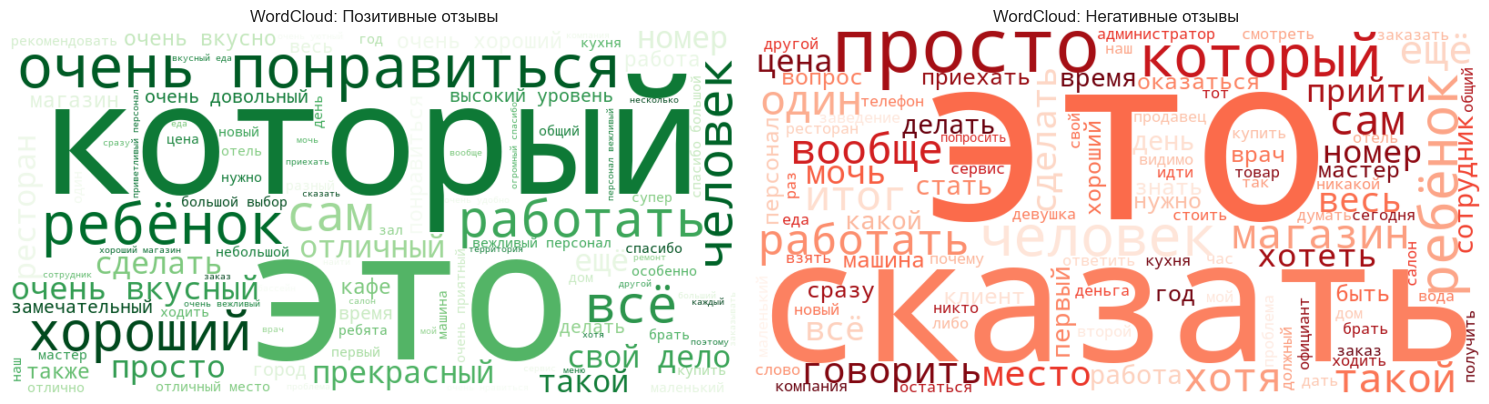

In [13]:
# ЗАДАНИЕ: Проведите частотный анализ слов и создайте облака слов для позитивных и негативных отзывов.
all_words = ' '.join(df_processed['processed_text']).split()
word_freq = Counter(all_words)
vocab_size = len(word_freq)

print(f"\nРазмер словаря после обработки: {vocab_size} уникальных слов")
print(f"Топ-20 самых частых слов:")
for word, freq in word_freq.most_common(20):
    print(f"   {word:15} : {freq:5} раз")


# WordCloud для позитивных и негативных отзывов
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Позитивные
positive_text = ' '.join(
    df_processed[df_processed['sentiment'] == 1]['processed_text'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white',
                          colormap='Greens', max_words=100).generate(positive_text)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title('WordCloud: Позитивные отзывы')
axes[0].axis('off')

# Негативные
negative_text = ' '.join(
    df_processed[df_processed['sentiment'] == 0]['processed_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white',
                          colormap='Reds', max_words=100).generate(negative_text)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].set_title('WordCloud: Негативные отзывы')
axes[1].axis('off')

plt.tight_layout()
plt.show()

-----
---

## **3. TF-IDF + LogisticRegression**

Векторизуем текст с помощью TF-IDF и обучим модель логистической регрессии.

- Подберите оптимальные параметры TfidfVectorizer (например, max_features, ngram_range), оценивая F1-score на валидационной выборке.  
- Обучите LogisticRegression на лучших TF-IDF признаках.  
- Оцените итоговое качество на тестовой выборке. Выведите отчет с метриками и confusion matrix.  
- Проанализируйте важность признаков (коэффициенты модели).  


In [14]:
df = df_processed.copy()

In [15]:
# Разделение данных на обучающую, валидационную и тестовую выборки
X = df['processed_text']
y = df['sentiment']

# Немного изменим разбиения, так как планируется поиск параметров
# черз кросс-валидацию
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [18]:
# ЗАДАНИЕ: Проведите эксперименты с различными параметрами TfidfVectorizer (max_features, ngram_range и т.д.).
# Обучите LogisticRegression на каждой конфигурации и выберите лучшую по метрике F1 на валидационной выборке.
# Определяем параметры для перебора

# Создаем пайплайн для упрощения процесса валидации
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False)),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=500))
])

# Определяем сетку параметров для поиска
param_dist = {
    'tfidf__max_features': [500, 1000],
    'tfidf__min_df': [1, 2, 3, 5],
    'tfidf__max_df': [0.7, 0.8, 0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'lr__C':[0.1, 0.01, 0.001],
}

# Выполняем рандомизированный поиск (для снижения вычислетиельной нагрузки)
# поиск по сетке выглядит дорогостоящим
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist,
    n_iter=50, 
    scoring='f1_weighted',
    cv=3,  
    random_state=RANDOM_STATE,
    n_jobs=-1  
)

# Запускаем поиск
random_search.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", random_search.best_params_)
print("Лучший F1-score (кросс-валидация):", random_search.best_score_)


Лучшие параметры: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 1, 'tfidf__max_features': 1000, 'tfidf__max_df': 0.7, 'lr__C': 0.1}
Лучший F1-score (кросс-валидация): 0.9234981347557297


In [19]:
# Получаем предсказание на валидационной выборке
y_val_pred_tfidf = random_search.predict(X_val)
y_val_pred_proba_tfidf = random_search.predict_proba(X_val)

In [18]:
# ЗАДАНИЕ: Рассчитайте и выведите метрики (Accuracy, Precision, Recall, F1, ROC_AUC) и confusion matrix.
# напишем функцию

def metrics_calc(y_val, y_val_pred, y_val_pred_proba, name=None, print_metrics=True):

    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_pred_proba[:, 1])
    cm_w2v = confusion_matrix(y_val, y_val_pred)

    if print_metrics:
        print(f"Accuracy на валидации: {accuracy:.4f}")
        print(f"Precision на валидации: {precision:.4f}")
        print(f"Recall на валидации: {recall:.4f}")
        print(f"F1-Score на валидации: {f1:.4f}")
        print(f"ROC-AUC на валидации: {roc_auc:.4f}\n")

        print(
            f"Точность на негативных отзывах:  {cm_w2v[0, 0] / (cm_w2v[0, 1] + cm_w2v[0, 0]):.3f}")
    else:
        pass

    result_dict = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
    }

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_w2v, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Негативный', 'Позитивный'],
                yticklabels=['Негативный', 'Позитивный'])
    plt.title(f'Confusion Matrix: {name} + LogisticRegression')
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')
    plt.show()

    return result_dict


Accuracy на валидации: 0.9248
Precision на валидации: 0.9293
Recall на валидации: 0.9197
F1-Score на валидации: 0.9245
ROC-AUC на валидации: 0.9759

Точность на негативных отзывах:  0.930


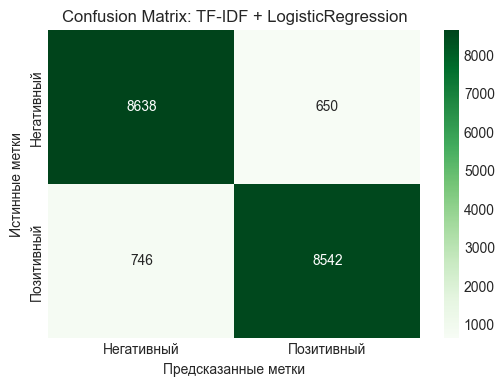

In [21]:
# Вызовем ее
result_tfidf = metrics_calc(y_val, y_val_pred_tfidf,
                            y_val_pred_proba_tfidf, name="TF-IDF")

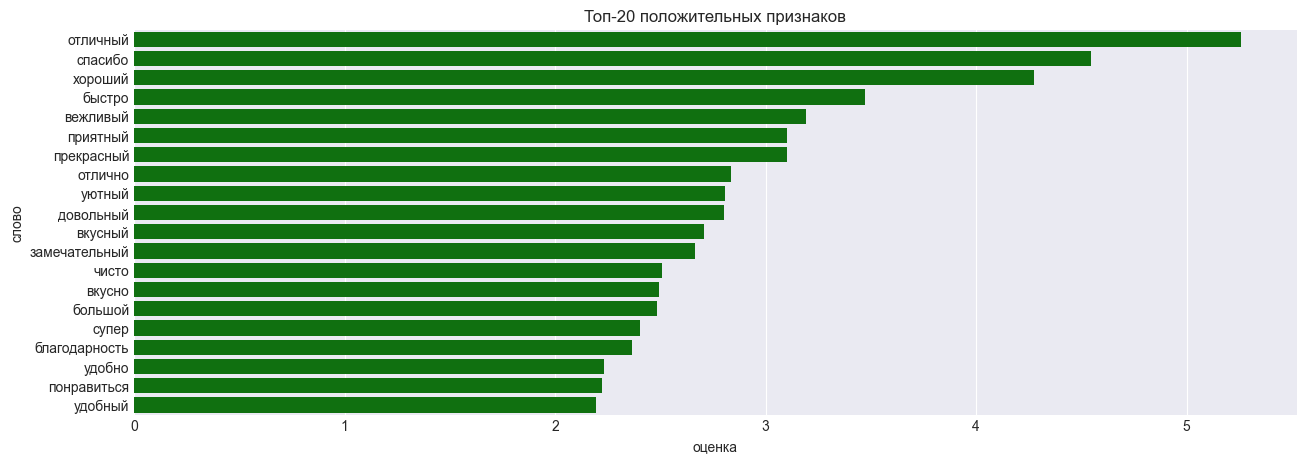

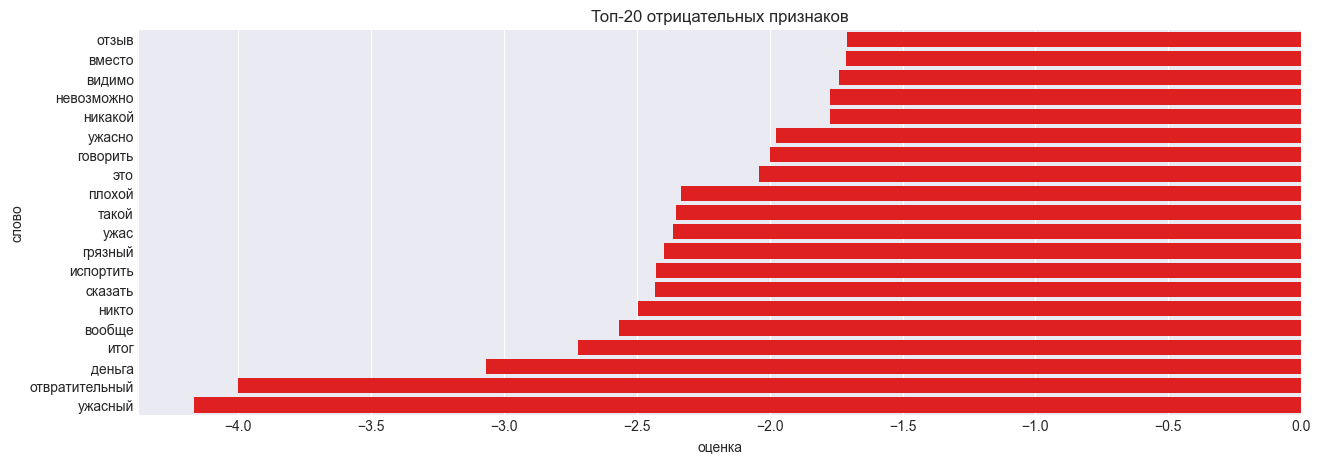

In [72]:
# Анализ важности признаков
best_model = random_search.best_estimator_
vectorizer = best_model.named_steps['tfidf']
lr_model = best_model.named_steps['lr']

# Получаем имена признаков и коэффициенты
feature_names = vectorizer.get_feature_names_out()
coefs = lr_model.coef_[0]

# Создаем DataFrame для удобства
coef_df = pd.DataFrame({'слово': feature_names, 'оценка': coefs})
coef_df = coef_df.sort_values('оценка', ascending=False)

top_20 = coef_df.head(20)
worst_20 = coef_df.tail(20)

plt.figure(figsize=(15, 5))
sns.barplot(top_20, x='оценка', y='слово', orient="h", color='green')
plt.title('Топ-20 положительных признаков')
plt.show()

plt.figure(figsize=(15, 5))
sns.barplot(worst_20, x='оценка', y='слово', orient="h", color='red')
plt.title('Топ-20 отрицательных признаков')
plt.show()

In [62]:
# Сохранение лучшей модели
with open('models/tfidf_lr.pkl', 'wb') as f:
    pickle.dump(random_search, f)

-----
---

## **4. Word2Vec embeddings**

Теперь используем Word2Vec для получения векторных представлений текста.

- Обучите собственную модель Word2Vec на обучающей выборке. Подберите оптимальные параметры (vector_size, window, sg), оценивая F1-score классификатора на валидации.  
- Реализуйте функцию получения вектора документа путем усреднения векторов слов.
- Обучите LogisticRegression на полученных векторах.
- Оцените качество на тестовой выборке.

In [16]:
# Т.к. я использую пайплай, то придедтся создать свой класс-токенизатор
# для использования в качестве шага, в частности внедрим функцию преобразования текса в вектор путём усреднения векторов слов.

# Создаем кастомный трансформер для Word2Vec
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    # Инициализируем основными параметрами которые полетят в W2V
    def __init__(self, vector_size=100, window=5, min_count=2, sg=0, workers=4, seed=RANDOM_STATE):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.sg = sg
        self.workers = workers
        self.seed = seed
        self.model = None
        self.vocab = None
        
    def fit(self, X, y=None):
        self.model = Word2Vec(
            sentences=X,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            sg=self.sg,
            workers=self.workers,
            seed=self.seed
        )
        return self
        
    def transform(self, X):
        # Преобразуем каждый текст в вектор
        return np.array([self._text_to_vector(text) for text in X])
    
    # внутренний метод, векторизирующий и возвращающий среднюю длинну (имплементация с. семинара)
    def _text_to_vector(self, text):
        word_vectors = [
            self.model.wv[word] for word in text 
            if word in self.model.wv
        ]
        if len(word_vectors) == 0:
            return np.zeros(self.vector_size)
        return np.mean(word_vectors, axis=0)

# Подготовка данных
tokenized_texts_train = [text.split() for text in X_train]
tokenized_texts_val = [text.split() for text in X_val]

In [ ]:
# Пайплайн с кастомным трансформером
pipeline_w2v = Pipeline([
    ('w2v', Word2VecTransformer(workers=4, seed=RANDOM_STATE)),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=500))
])


# Сетка параметров
param_grid = {
    'w2v__vector_size': [50, 100],
    'w2v__window': [2, 3, 5],
    'w2v__min_count': [2, 3, 5],
    'w2v__sg': [0, 1],
    'lr__C': [0.1, 0.01, 0.001]
}

# Поиск по сетке
w2v_search = RandomizedSearchCV(
    pipeline_w2v,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1_weighted',
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Запуск поиска на токенизированных текстах
w2v_search.fit(tokenized_texts_train, y_train)

# Вывод результатов
print("Лучшие параметры:", w2v_search.best_params_)
print("Лучший F1-score (кросс-валидация):", w2v_search.best_score_)

Лучшие параметры: {'w2v__window': 5, 'w2v__vector_size': 100, 'w2v__sg': 1, 'w2v__min_count': 5, 'lr__C': 0.1}
Лучший F1-score (кросс-валидация): 0.9349487381085558


Accuracy на валидации: 0.9357
Precision на валидации: 0.9434
Recall на валидации: 0.9270
F1-Score на валидации: 0.9351
ROC-AUC на валидации: 0.9785

Точность на негативных отзывах:  0.944


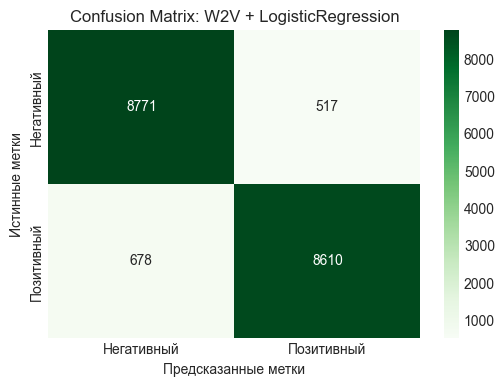

In [75]:
# Финальная оценка лучшей модели  на валидацонной выборке
y_val_pred_w2v = w2v_search.best_estimator_.predict(tokenized_texts_val)
y_val_pred_proba_w2v = w2v_search.best_estimator_.predict_proba(
    tokenized_texts_val)

# ЗАДАНИЕ: Рассчитайте метрики и выведите confusion matrix.
# Вызовем ее
result_w2v = metrics_calc(y_val, y_val_pred_w2v,
                            y_val_pred_proba_w2v, name="W2V")

In [ ]:
# Анализ семантических отношений (найти похожие слова)
# Получаем лучшую модель из поиска
best_model = w2v_search.best_estimator_.named_steps['w2v'].model

# Функция для поиска похожих слов
def find_similar_words(model, word, topn=10):
    """
    Находит слова, наиболее похожие на заданное слово
    return : Тщту 
    """
    try:
        similar_words = model.wv.most_similar(word, topn=topn)
        print(f"Слова, похожие на '{word}':")
        for word, similarity in similar_words:
            print(f"  {word}: {similarity:.4f}")
    except KeyError:
        print(f"Слово '{word}' отсутствует в словаре модели")

# Анализ семантических отношений для нескольких примеров
words_to_check = ['отзыв', 'ужасно', 'обслуживание', 'чисто', 'культура']

In [ ]:
for word in words_to_check:
    find_similar_words(best_model, word)
    print()
    

Слова, похожие на 'отзыв':
  хвалебный: 0.7685
  nотзыв: 0.7408
  рейтинг: 0.7310
  отрицательный: 0.7132
  прочитать: 0.6971
  накипеть: 0.6955
  восторженный: 0.6954
  комментарий: 0.6946
  почитать: 0.6883
  начитаться: 0.6815

Слова, похожие на 'ужасно':
  дико: 0.7445
  жутко: 0.7144
  хреновый: 0.7029
  отвратительный: 0.6888
  отвратно: 0.6816
  ужас: 0.6773
  кошмарный: 0.6617
  ужасный: 0.6614
  плохо: 0.6593
  безобразно: 0.6546

Слова, похожие на 'обслуживание':
  nобслуживание: 0.7722
  выш: 0.7085
  обслуга: 0.6968
  сервис: 0.6966
  предупредительный: 0.6869
  nсервис: 0.6754
  обслуживающий: 0.6732
  персанал: 0.6691
  экстерьер: 0.6663
  nобслуживающий: 0.6642

Слова, похожие на 'чисто':
  чистенько: 0.8805
  просторно: 0.8501
  nчисто: 0.8004
  чистый: 0.7822
  чистенький: 0.7817
  опрятно: 0.7816
  nчистота: 0.7590
  цивильно: 0.7586
  светло: 0.7550
  скромненький: 0.7475

Слова, похожие на 'культура':
  сельский: 0.7258
  республика: 0.7172
  наследие: 0.7151
  изоб

In [77]:
# Сохранение лучшей модели
with open('models/w2v_lr.pkl', 'wb') as f:
    pickle.dump(w2v_search, f)

-----
---

## **5. FastText embeddings**

Обучим модель FastText и сравним ее с Word2Vec.

- Обучите модель FastText.
- По аналогии с Word2Vec, получите векторы документов и обучите классификатор.
- Оцените качество на тестовой выборке.
- Продемонстрируйте преимущество FastText на OOV-словах (словах, отсутствующих в словаре).


## Пайплайн-подход уронил машину, пришлось брать дефолтный вариант, но и он показал себя лучше

In [ ]:
# ЗАДАНИЕ: Обучите модель FastText с параметрами по вашему выбору.
class FastTextTransformer(Word2VecTransformer):
    def __init__(self, vector_size=100, window=5, min_count=2, sg=0, workers=3,
                 seed=RANDOM_STATE, min_n=3, max_n=6, hs=0, alpha=0.025):
        super().__init__(
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            sg=sg,
            workers=workers,
            seed=seed
        )
        self.min_n = min_n
        self.max_n = max_n
        self.hs = hs
        self.alpha = alpha

    def fit(self, X, y=None):
        self.model = FastText(
            sentences=X,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            sg=self.sg,
            workers=self.workers,
            seed=self.seed,
            min_n=self.min_n,
            max_n=self.max_n,
            hs=self.hs,
            alpha=self.alpha
        )
        return self
    
    def _text_to_vector(self, text):
        """
        Преобразует текст в вектор путём усреднения векторов слов.
        """
        words = text.split()
        word_vectors = []

        for word in words:
            if word in self.model.wv:
                word_vectors.append(self.model.wv[word])

        if len(word_vectors) == 0:
            # Если ни одно слово не найдено, возвращаем нулевой вектор
            return np.zeros(self.model.wv.vector_size)

        # Усредняем векторы слов
        return np.mean(word_vectors, axis=0)


# Пайплайн с кастомным трансформером
pipeline_ft = Pipeline([
    ('ft', FastTextTransformer(seed=RANDOM_STATE)),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=500))
])

In [ ]:
# Расширенная сетка параметров для FastText
param_grid_ft = {
    'ft__vector_size': [150],
    'ft__window': [5],
    'ft__min_count': [2],
    'ft__sg': [0, 1],  
    'ft__min_n': [2], 
    'ft__max_n': [6],  
    'ft__alpha': [0.01],  
    'lr__C': [0.001],
}

# Векторизация и обучение классификатора
ft_search = RandomizedSearchCV(
    pipeline_ft,
    param_distributions=param_grid_ft,
    n_iter=30,  # Количество итераций
    scoring='f1_weighted',
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

# Запуск поиска
ft_search.fit(tokenized_texts_train, y_train)

# Вывод результатов
print("Лучшие параметры:", ft_search.best_params_)
print("Лучший F1-score (кросс-валидация):", ft_search.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [ ]:
# Финальная оценка лучшей модели  на валидацонной выборке
y_val_pred_ft = ft_search.best_estimator_.predict(tokenized_texts_val)
y_val_pred_proba_ft = ft_search.best_estimator_.predict_proba(
    tokenized_texts_val)

# ЗАДАНИЕ: Рассчитайте метрики и выведите confusion matrix.
# Вызовем ее
result_ft = metrics_calc(y_val, y_val_pred_ft,
                            y_val_pred_proba_ft, name="FastText")

In [19]:
# Железо не смогло вывезти рандомизированный поиск, так что используем модель с базовыми параметрами с семинара
fasttext_model = FastText(
    sentences=tokenized_texts_train,
    vector_size=100,
    window=5,
    min_count=2,
    min_n=3,
    max_n=6,
    sg=1,
    epochs=100,
    seed=42
)
print(f"Обучено, словарь: {len(fasttext_model.wv)} слов")

def text_to_vector(text, model):
    """
    Преобразует текст в вектор путём усреднения векторов слов.
    """
    words = text.split()
    word_vectors = []

    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])

    if len(word_vectors) == 0:
        # Если ни одно слово не найдено, возвращаем нулевой вектор
        return np.zeros(model.wv.vector_size)

    # Усредняем векторы слов
    return np.mean(word_vectors, axis=0)

X_train_ft = np.array([text_to_vector(text, fasttext_model) for text in tqdm(X_train)])
X_test_ft = np.array([text_to_vector(text, fasttext_model) for text in tqdm(X_val)])


Обучено, словарь: 38052 слов


  0%|          | 0/74302 [00:00<?, ?it/s]

  0%|          | 0/18576 [00:00<?, ?it/s]

In [21]:
# Сохранение модели эмбедера
with open('models/ft_embeder.pkl', 'wb') as f:
    pickle.dump(fasttext_model, f)

Accuracy на валидации: 0.9377
Precision на валидации: 0.9455
Recall на валидации: 0.9288
F1-Score на валидации: 0.9371
ROC-AUC на валидации: 0.9788

Точность на негативных отзывах:  0.946


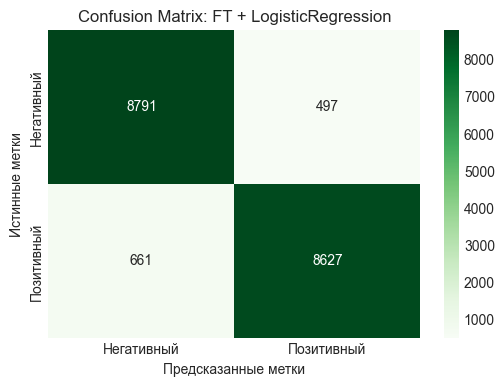

In [25]:
# Дефолтная логрег
lr_ft = LogisticRegression(
    C=1.0,
    solver='liblinear',
    random_state=42
)

lr_ft.fit(X_train_ft, y_train)


# Предсказания
y_pred_ft = lr_ft.predict(X_test_ft)
y_pred_ft_proba = lr_ft.predict_proba(X_test_ft)

# Метрики
result_ft = metrics_calc(y_val, y_pred_ft,
                            y_pred_ft_proba, name="FT")

> Даже на дефолтных параметрах без поиска по сетке FT обходит W2V

In [ ]:
# Так как эксперименты с рандомным поиском параметров 4 раза закрашили машину, прижется тащиить модель эмбедингов из пикла
with open('./models/w2v_lr.pkl', 'rb') as f:
    w2v = pickle.load(f)
    
print("Model loaded!")
w2v_model = w2v.best_estimator_.named_steps['w2v'].model # вытаскиваем токенизатор из пайпа для сравнения оов

Model loaded!


In [45]:
def evaluate_embeddings(model, model_name):
    """Оценивает качество эмбеддингов на стандартных задачах"""
    results = {}

    if hasattr(model, 'wv'):
        oov_words = ['несуществующееслово', 'абракадабра123',
                     'хзчтоэто', 'qwertyuiop', 'фывапролдж']
        oov_handled = sum(1 for word in oov_words if word in model.wv)
        results['oov_handling'] = oov_handled / len(oov_words)

        print(f"Результаты для {model_name}:")
        print(
            f"Обработка OOV: {results['oov_handling']:.3f} ({oov_handled}/{len(oov_words)})")

        if isinstance(model, FastText):
            oov_subword = sum(
                1 for word in oov_words if len(model.wv[word]) > 0)
            print(
                f"  FastText поддерживает субсловные векторы: {oov_subword}/{len(oov_words)}")

    else:
        print(
            f"⚠️ Модель {model_name} не является моделью эмбеддингов (нет атрибута '.wv'). Пропускаем.")
        results['oov_handling'] = None

    return results


print("=== Оценка моделей эмбеддингов ===")


results_ft = evaluate_embeddings(fasttext_model, "FastText")
results_w2v = evaluate_embeddings(w2v_model, "w2v")

=== Оценка моделей эмбеддингов ===
Результаты для FastText:
Обработка OOV: 1.000 (5/5)
  FastText поддерживает субсловные векторы: 5/5
Результаты для w2v:
Обработка OOV: 0.000 (0/5)


-----
___

## **6. Отчеты и выводы**
### **6.1. Визуализация и анализ**

Сравним все полученные модели и визуализируем результаты.

- Подготовьте сводную таблицу и/или график со сравнительными метриками всех моделей.
- Визуализируйте эмбеддинги с помощью t-SNE.
- Проанализируйте ошибки моделей.


  0%|          | 0/74302 [00:00<?, ?it/s]

  0%|          | 0/18576 [00:00<?, ?it/s]

Accuracy на валидации: 0.9377
Precision на валидации: 0.9455
Recall на валидации: 0.9288
F1-Score на валидации: 0.9371
ROC-AUC на валидации: 0.9788

Точность на негативных отзывах:  0.946


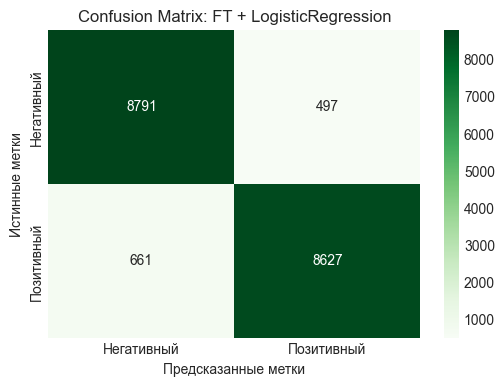

In [20]:
# Загружаем модели
# TF_IDF
with open('./models/tfidf_lr.pkl', 'rb') as f:
    tf_idf_lr = pickle.load(f)

# w2V
with open('./models/w2v_lr.pkl', 'rb') as f:
    w2v = pickle.load(f)

# Токенизатор FastText затем дефолтная LR (вобщем из-за того что железо не тянет воспроизводим без красоты)
with open('./models/ft_embeder.pkl', 'rb') as f:
    ft_embeder = pickle.load(f)
    
def text_to_vector(text, model):
    """
    Преобразует текст в вектор путём усреднения векторов слов.
    """
    words = text.split()
    word_vectors = []

    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])

    if len(word_vectors) == 0:
        # Если ни одно слово не найдено, возвращаем нулевой вектор
        return np.zeros(model.wv.vector_size)

    # Усредняем векторы слов
    return np.mean(word_vectors, axis=0)

X_train_ft = np.array([text_to_vector(text, ft_embeder) for text in tqdm(X_train)])
X_test_ft = np.array([text_to_vector(text, ft_embeder) for text in tqdm(X_val)])

# Дефолтная логрег
lr_ft = LogisticRegression(
    C=1.0,
    solver='liblinear',
    random_state=42
)

lr_ft.fit(X_train_ft, y_train)


# Предсказания
y_pred_ft = lr_ft.predict(X_test_ft)
y_pred_ft_proba = lr_ft.predict_proba(X_test_ft)

# Метрики
result_ft = metrics_calc(y_val, y_pred_ft,
                            y_pred_ft_proba, name="FT")

Accuracy на валидации: 0.9357
Precision на валидации: 0.9434
Recall на валидации: 0.9270
F1-Score на валидации: 0.9351
ROC-AUC на валидации: 0.9785

Точность на негативных отзывах:  0.944


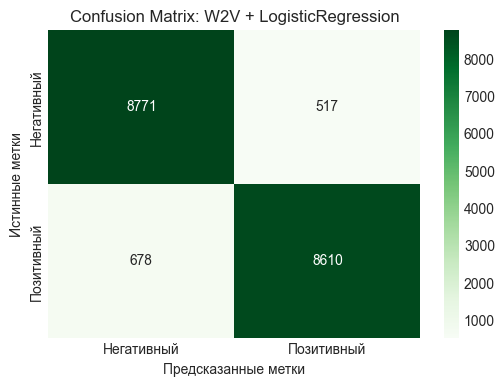

In [21]:
# Финальная оценка лучшей модели  на валидацонной выборке
y_val_pred_w2v = w2v.best_estimator_.predict(tokenized_texts_val)
y_val_pred_proba_w2v = w2v.best_estimator_.predict_proba(
    tokenized_texts_val)

# ЗАДАНИЕ: Рассчитайте метрики и выведите confusion matrix.
# Вызовем ее
result_w2v = metrics_calc(y_val, y_val_pred_w2v,
                            y_val_pred_proba_w2v, name="W2V")

Accuracy на валидации: 0.9248
Precision на валидации: 0.9293
Recall на валидации: 0.9197
F1-Score на валидации: 0.9245
ROC-AUC на валидации: 0.9759

Точность на негативных отзывах:  0.930


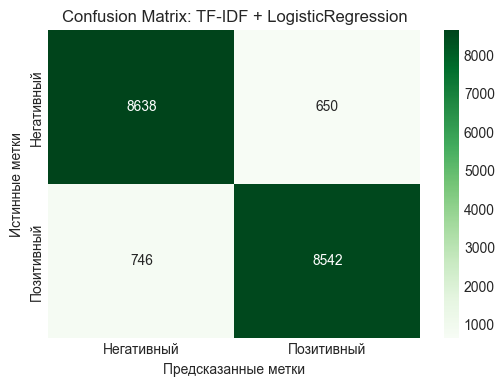

In [22]:
# Вызовем ее
y_val_pred_tfidf = tf_idf_lr.best_estimator_.predict(X_val)
y_val_pred_proba_tfidf = tf_idf_lr.best_estimator_.predict_proba(
    X_val)

result_tfidf = metrics_calc(y_val, y_val_pred_tfidf,
                            y_val_pred_proba_tfidf, name="TF-IDF")

In [23]:
# ЗАДАНИЕ: Создайте сравнительную таблицу и графики для метрик всех моделей.
# Сравнительная таблица
result_tfidf["Model"] = "TF_IDF"
result_w2v["Model"] = "W2V"
result_ft["Model"] = "FastText"

result_tfidf = pd.Series(result_tfidf)
result_w2v = pd.Series(result_w2v)
result_ft = pd.Series(result_ft)

result_table = pd.DataFrame([result_w2v, result_tfidf, result_ft])
result_table

,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Model
0,0.935670,0.943355,0.927003,0.935107,0.978468,W2V
1,0.924849,0.929286,0.919681,0.924459,0.975945,TF_IDF
2,0.937661,0.945528,0.928833,0.937106,0.978788,FastText


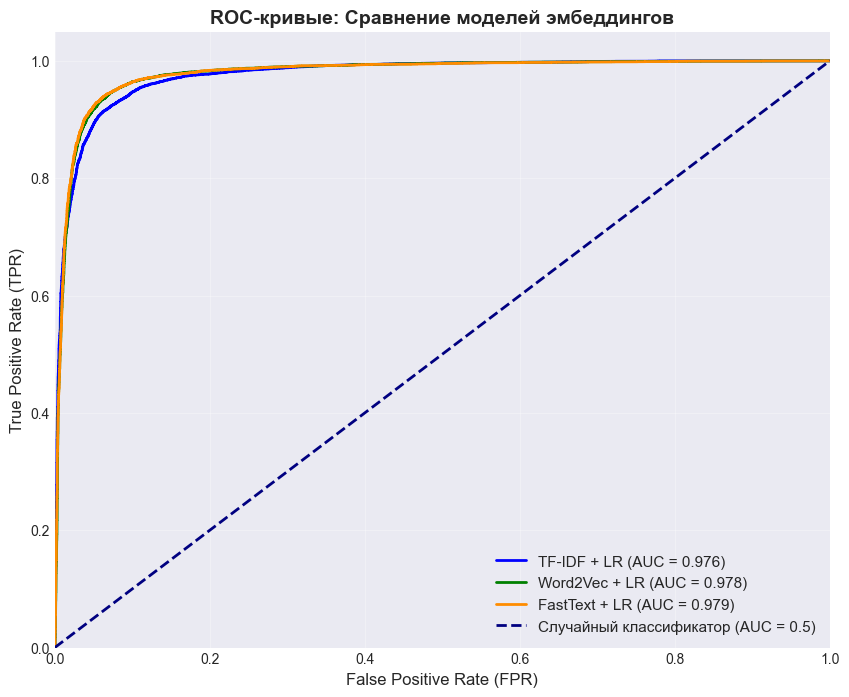

=== AUC по моделям ===
TF-IDF + LR:   0.9759
Word2Vec + LR: 0.9785
FastText + LR: 0.9788


In [24]:
# Постройте общую ROC-кривую.
y_proba_tfidf = y_val_pred_proba_tfidf[:, 1]
y_proba_w2v = y_val_pred_proba_w2v[:, 1]
y_proba_ft = y_pred_ft_proba[:, 1]

# Вычисляем FPR, TPR и пороги
fpr, tpr, thresholds = roc_curve(y_val, y_proba_ft)

# Вычисляем ROC для каждой модели ---
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_val, y_proba_tfidf)
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)

fpr_w2v, tpr_w2v, _ = roc_curve(y_val, y_proba_w2v)
roc_auc_w2v = auc(fpr_w2v, tpr_w2v)

fpr_ft, tpr_ft, _ = roc_curve(y_val, y_proba_ft)
roc_auc_ft = auc(fpr_ft, tpr_ft)

# Строим общий график 
plt.figure(figsize=(10, 8))

plt.plot(fpr_tfidf, tpr_tfidf, color='blue', lw=2,
         label=f'TF-IDF + LR (AUC = {roc_auc_tfidf:.3f})')
plt.plot(fpr_w2v, tpr_w2v, color='green', lw=2,
         label=f'Word2Vec + LR (AUC = {roc_auc_w2v:.3f})')
plt.plot(fpr_ft, tpr_ft, color='darkorange', lw=2,
         label=f'FastText + LR (AUC = {roc_auc_ft:.3f})')

# Линия случайного классификатора
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Случайный классификатор (AUC = 0.5)')

# Настройки графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC-кривые: Сравнение моделей эмбеддингов',
          fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

plt.show()

# Вывод AUC
print("=== AUC по моделям ===")
print(f"TF-IDF + LR:   {roc_auc_tfidf:.4f}")
print(f"Word2Vec + LR: {roc_auc_w2v:.4f}")
print(f"FastText + LR: {roc_auc_ft:.4f}")

> FastText обходит остальные модели, учитывая, что параметры были дефолтными. Word2Vec показал сравнительнын результаты на моей машине, при этом не убив ее, лично я бы использовал его в работе.

  0%|          | 0/18576 [00:00<?, ?it/s]

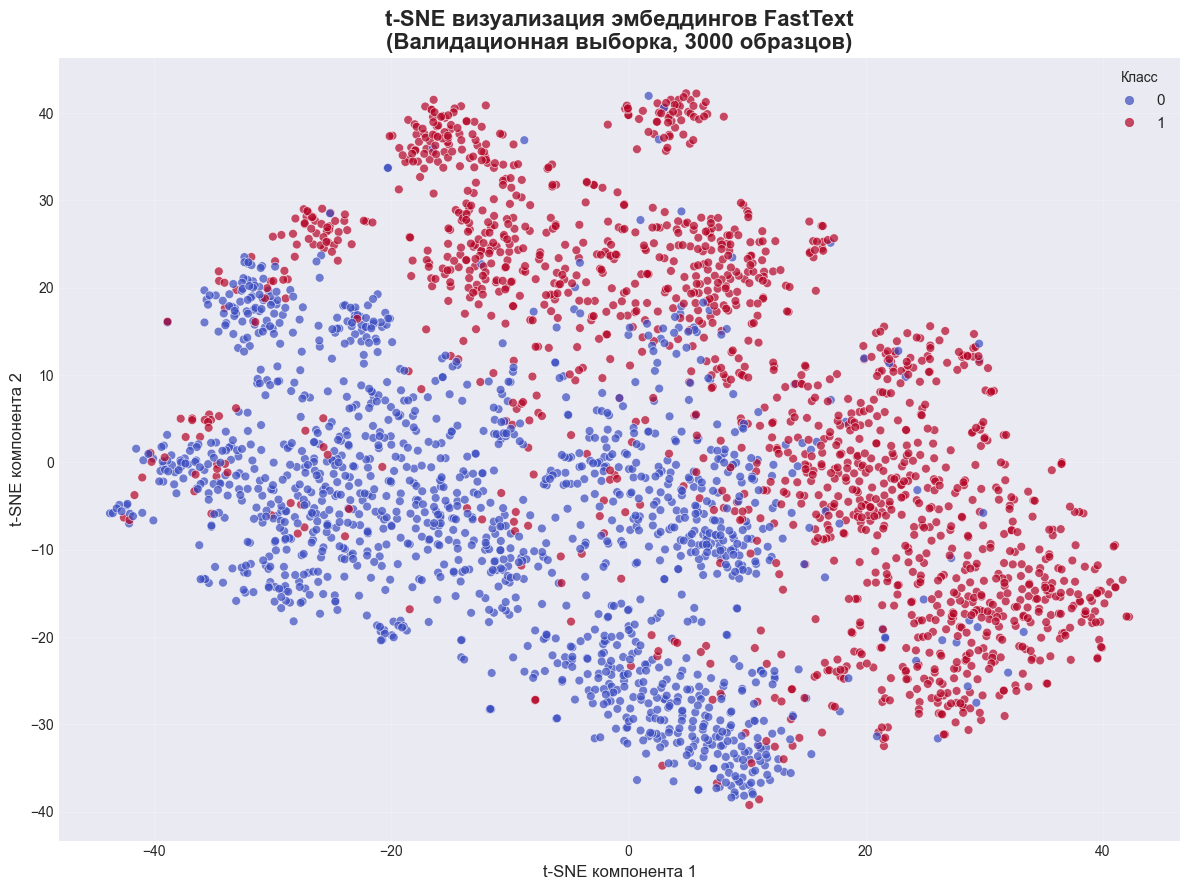

In [ ]:
# t-SNE визуализация эмбеддингов
# (Используйте эмбеддинги лучшей модели Word2Vec или FastText)

X_val_reset = X_val.reset_index(
    drop=True) if isinstance(X_val, pd.Series) else X_val
y_val_reset = y_val.reset_index(
    drop=True) if isinstance(y_val, pd.Series) else y_val


def text_to_vector(text, model):
    words = text.split()
    word_vectors = []
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if len(word_vectors) == 0:
        return np.zeros(model.wv.vector_size)
    return np.mean(word_vectors, axis=0)


# Вычисляем вектора для всего X_val
X_val_ft = np.array([text_to_vector(text, ft_embeder)
                    for text in tqdm(X_val_reset)])


n_samples = 3000  # Хватит для наглядности
indices = np.random.choice(len(X_val_ft), size=n_samples, replace=False)

X_tsne_sample = X_val_ft[indices]
y_tsne_sample = y_val_reset.iloc[indices] if hasattr(
    y_val_reset, 'iloc') else y_val_reset[indices]

# Применяем t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=1000,
    random_state=42,
    init='pca',
    learning_rate='auto'
)
X_tsne = tsne.fit_transform(X_tsne_sample)

# Визуализируем
plt.figure(figsize=(12, 9))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=y_tsne_sample,
    cmap='coolwarm',
    alpha=0.7,
    s=40,
    edgecolors='w',
    linewidth=0.5
)

plt.title('t-SNE визуализация эмбеддингов FastText\n(Валидационная выборка, 3000 образцов)',
          fontsize=16, fontweight='bold')
plt.xlabel('t-SNE компонента 1', fontsize=12)
plt.ylabel('t-SNE компонента 2', fontsize=12)
plt.legend(*scatter.legend_elements(), title="Класс",
           loc="upper right", fontsize=11)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

> Достаточно хорошо разделяет классы

In [ ]:
# Анализ ошибок
# Создаём DataFrame с данными
errors_df = pd.DataFrame({
    'text': X_val.values, 
    'true_label': y_val,
    'pred_tfidf': y_val_pred_tfidf,
    'pred_w2v': y_val_pred_w2v,
    'pred_ft': y_pred_ft
})

# Добавляем столбец: "Все модели ошиблись"
errors_df['all_wrong'] = (
    (errors_df['pred_tfidf'] != errors_df['true_label']) &
    (errors_df['pred_w2v'] != errors_df['true_label']) &
    (errors_df['pred_ft'] != errors_df['true_label'])
)

# Фильтруем только те примеры, где все три модели ошиблись
common_errors = errors_df[errors_df['all_wrong']].copy()

display(common_errors)
print(common_errors.shape[0], "количество общих ощибок")

,text,true_label,pred_tfidf,pred_w2v,pred_ft,all_wrong
48666,значит прийти май сожаление поза классический ...,1,0,0,0,True
60042,очень вкусный пицца интересный небанальный мен...,1,0,0,0,True
11257,хотеть поделиться свой опыт посещение магазин ...,0,1,1,1,True
20770,прекрасный беседка день проводить спасибо огро...,0,1,1,1,True
16680,место устареть скучный интерьер ребёнок посиде...,0,1,1,1,True
...,...,...,...,...,...,...
30219,клуб зал групповой занятие кардиозона два зал ...,0,1,1,1,True
43342,лето пока делать нечего территория больший кро...,0,1,1,1,True
68273,отличный магазин понимать писать цена завысить...,1,0,0,0,True
39550,атмосфера зал акустика слышный каждый шорох со...,0,1,1,1,True


744 количество общих ощибок


-----

### **6.2. Подготовка отчетов**

Подготовьте итоговый отчет в формате Markdown.

- Проанализируйте ошибки моделей.
- Сформулируйте итоговые выводы (5-8 предложений): какой метод показал себя лучше и почему, в чем преимущества и недостатки каждого подхода, какие дальнейшие шаги по улучшению качества можно предпринять.

In [ ]:
# ЗАДАНИЕ: Сгенерируйте отчет, включающий описание данных, шаги предобработки,
# результаты моделей, сравнительный анализ, выводы и рекомендации.
report = f"""
# ОТЧЕТ ПО ДОМАШНЕМУ ЗАДАНИЮ

## 1. Описание данных

Исходный датасет содержит **500 000 отзывов** с полями:
- `address` - адрес места
- `name_ru` - название места (с небольшим количеством пропусков)
- `rating` - рейтинг от 1 до 5
- `rubrics` - категория места
- `text` - текст отзыва

Целевая переменная - `sentiment`, сформированная на основе `rating`:
- **Позитивный** (`1`) - рейтинг ≥ 4
- **Негативный** (`0`) - рейтинг ≤ 2  
(Отзывы с рейтингом 3 исключены как нейтральные)

### Проблема: Классовый дисбаланс
Изначально распределение классов было крайне несбалансированным:
- **Позитивные**: 431 675 (90.3%)
- **Негативные**: 46 439 (9.7%)

### Решение:
- **Сэмплирование** бОльшего класса по размером малого

## 2. Предобработка

### Этапы обработки:
1. **Очистка текста**:
   - Удаление HTML-тегов, URL, спецсимволов
   - Приведение к нижнему регистру
   - Удаление лишних пробелов

2. **Токенизация**:
   - Использован `nltk.word_tokenize()` с поддержкой русского языка
   - Удаление стоп-слов 

3. **Создание целевой переменной**:
   - `rating >= 4` → `sentiment = 1`
   - `rating <= 2` → `sentiment = 0`
   - `rating == 3` → исключены

## 3. Модели и методы
### Использованные модели:
| Модель | Описание |
|--------|----------|
| **Logistic Regression + TF-IDF** | Базовая модель на мешке слов |
| **Logistic Regression + Word2Vec** | Эмбеддинги на Word2Vec |
| **Logistic Regression + FastText** | Эмбеддинги на FastText |

### Сравнение моделей на валидационной выборке:

| Модель      | Accuracy | Precision | Recall   | F1-Score | ROC-AUC  |
|-------------|----------|-----------|----------|----------|----------|
| W2V         | 0.9357   | 0.9434    | 0.9270   | 0.9351   | 0.9785   |
| TF_IDF      | 0.9248   | 0.9293    | 0.9197   | 0.9245   | 0.9759   |
| FastText    | 0.9377   | 0.9455    | 0.9288   | 0.9371   | 0.9788   |


### Bыводы:
FastText - победитель среди трёх моделей. Несмотря на использование дефолтных параметров, он показал наилучшие результаты. Но вес итоговой модели-эмбедера и затраты по железу являются явными минусами.
Word2Vec - отличный компромисс. Его результаты почти не уступают FastText, но он требует меньше времени на обучение и меньше памяти. 
TF-IDF - базовый эталон. Показал хорошие результаты, но значительно уступает эмбеддингам. Подходит для быстрой прототипизации, но не для продакшена.
"""

# Сохранение отчета в формате markdown, вы можете использовать также pdf и docx
with open('reports/final_report.md', 'w', encoding='utf-8') as f:
    f.write(report)
print("Отчет сохранен в reports/final_report.md")

Отчет сохранен в reports/final_report.md


-----

## **Дополнительное задание по желанию**

За задание дополнительные баллы не ставятся. Оно выполняется по желанию студента.

In [ ]:
# Примеры бонусных заданий:
# 1. Ансамблирование моделей (усреднение вероятностей).
# 2. Кросс-валидация для более надежной оценки.
# 3. Использование предобученных эмбеддингов (например, из gensim-data).
# 4. Анализ интерпретируемости с LIME.
# 5. Загрузку Word2Vec модели из Семинара 1